In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dv003.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [4]:
%autoreload

cohort = mre_pinn.data.PatientCohort(xarray_dir='../data/NAFLD', patient_ids='0006')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/mask.nc
100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


In [5]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [6]:
%autoreload

pino = mre_pinn.model.SpectralTransformer(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_spatial_freqs=128,
    n_channels_model=128,
    n_spectral_blocks=0,
    n_hidden_layers=2,
    activ_fn='g',
    omega=15/300
)
pino

SpectralTransformer(
  (spectral_fwd): SpectralTransform(
    (a_linear): Linear(in_features=4, out_features=128, bias=True)
    (A_linear1): Linear(in_features=128, out_features=128, bias=True)
    (A_linear2): Linear(in_features=128, out_features=128, bias=True)
    (x_linear): Linear(in_features=3, out_features=128, bias=True)
  )
  (spectral_inv): SpectralInverse(
    (y_linear): Linear(in_features=3, out_features=128, bias=True)
    (U_linear1): Linear(in_features=128, out_features=128, bias=True)
    (U_linear2): Linear(in_features=128, out_features=128, bias=True)
    (u_linear): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [7]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-8, 1e0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000232 s



Training model...

Step      Train loss              Test loss               Test metric
0         [5.56e-04, 5.56e+04]    [5.56e-04, 5.56e+04]    []  


<IPython.core.display.Javascript object>


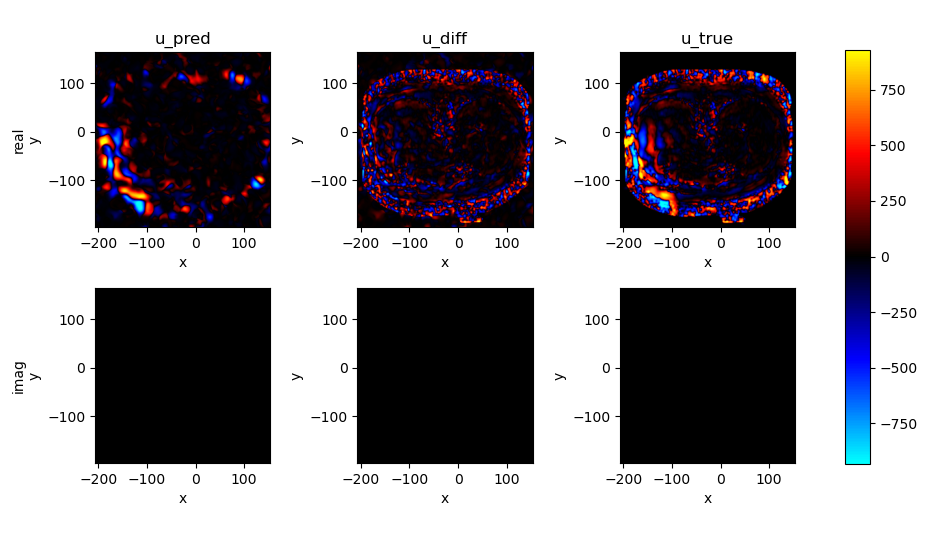

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

Time spent testing: 8.48%
10        [5.44e-04, 5.44e+04]    [5.44e-04, 5.44e+04]    []  
Time spent testing: 8.53%
20        [5.18e-04, 5.18e+04]    [5.18e-04, 5.18e+04]    []  
Time spent testing: 8.58%
30        [4.97e-04, 4.97e+04]    [4.97e-04, 4.97e+04]    []  
Time spent testing: 8.60%
40        [4.94e-04, 4.94e+04]    [4.94e-04, 4.94e+04]    []  
Time spent testing: 8.63%
50        [4.56e-04, 4.56e+04]    [4.56e-04, 4.56e+04]    []  
Time spent testing: 8.67%
60        [4.41e-04, 4.41e+04]    [4.41e-04, 4.41e+04]    []  
Time spent testing: 8.70%
70        [4.29e-04, 4.29e+04]    [4.29e-04, 4.29e+04]    []  
Time spent testing: 8.72%
80        [4.14e-04, 4.14e+04]    [4.14e-04, 4.14e+04]    []  
Time spent testing: 8.74%
90        [4.01e-04, 4.01e+04]    [4.01e-04, 4.01e+04]    []  
Time spent testing: 8.75%
100       [4.04e-04, 4.04e+04]    [4.04e-04, 4.04e+04]    []  
Time spent testing: 8.76%
110       [4.18e-04, 4.18e+04]    [4.18e-04, 4.18e+04]    []  
Time spent testing: 8


KeyboardInterrupt



In [8]:
model.train(10000, display_every=10, callbacks=[test_eval])